Columns: ['Year', 'Rulling_Party_BD', 'Rulling_Party_India', 'Killed', 'Injured', 'Abducted', 'Missing', 'Rape', 'Snatching', 'Push in', 'Other', 'Total', 'Source']


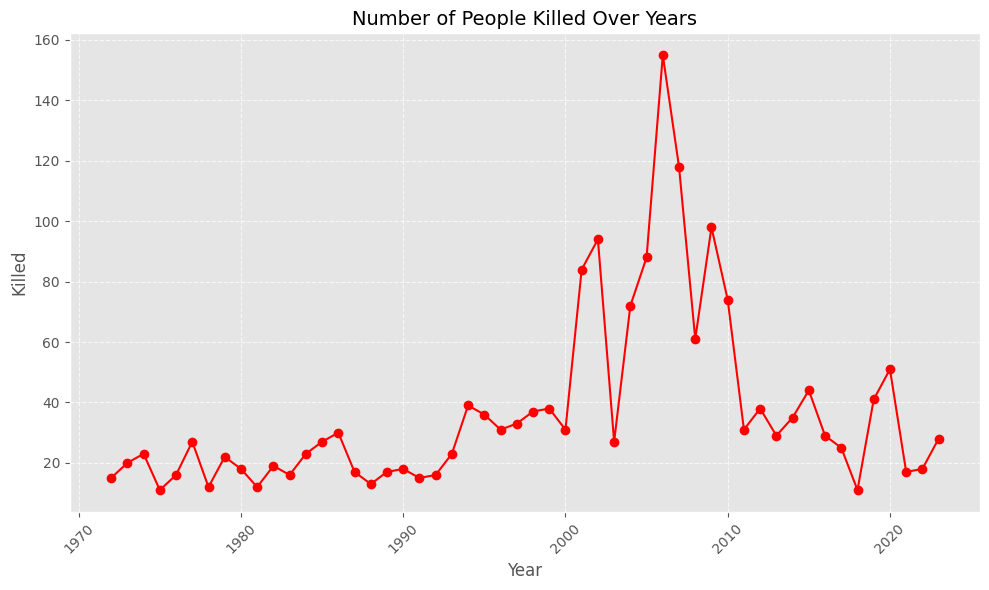

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # Try 'seaborn', 'fivethirtyeight', etc.

# Load the data from the Google Sheet (CSV export)
sheet_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRuhbCUX8qty3OiS_djxG0kCEODQAms8IX22Qdg-XcRir2hjdETsBSlG-KSHthWPOGd_13ePM9AGMmC/pub?output=csv"
df = pd.read_csv(sheet_url)

# Check column names (adjust if needed)
print("Columns:", df.columns.tolist())

# Ensure columns exist (case-sensitive!)
if 'Year' in df and 'Killed' in df:
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Killed'], marker='o', linestyle='-', color='red')
    
    # Customize the plot
    plt.title('Number of People Killed Over Years', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Killed', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()  # Prevents label cutoff
    plt.show()
else:
    print("Error: Columns 'Year' or 'Killed' not found in the data.")

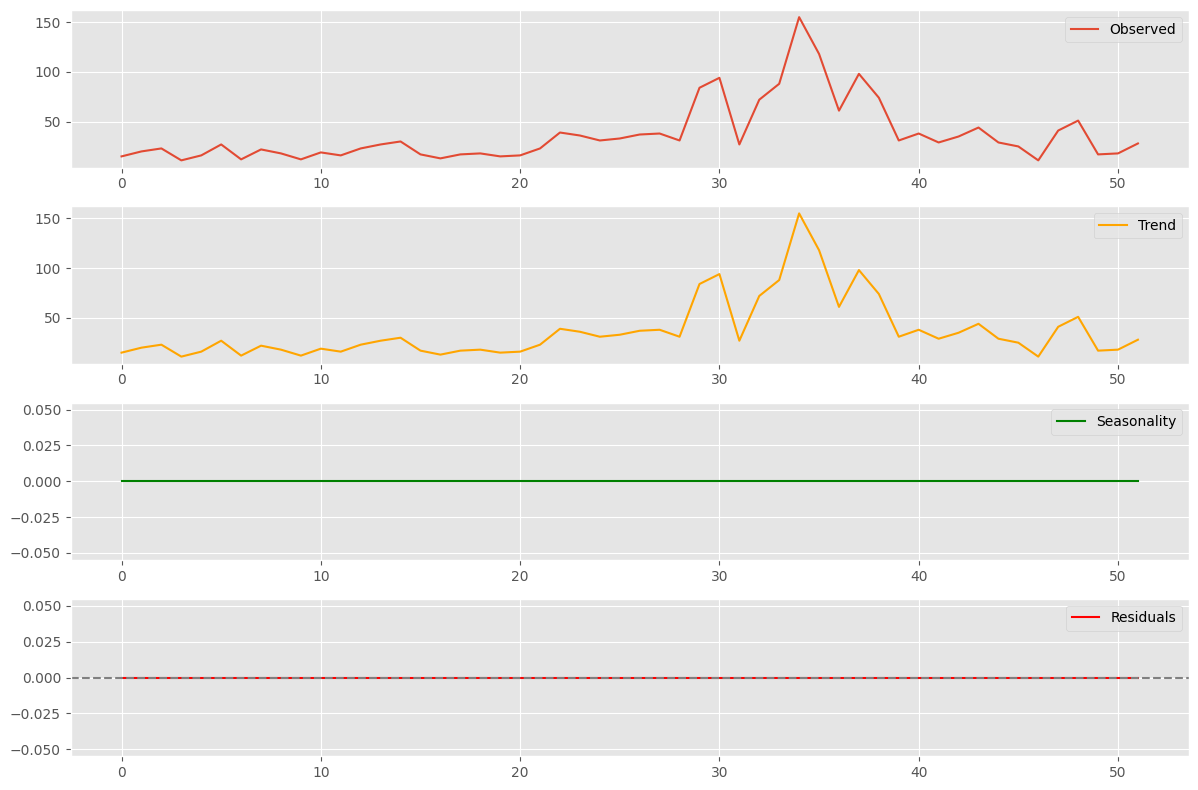

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose (assuming yearly data; adjust `period` if seasonal)
decomposition = seasonal_decompose(df['Killed'], model='additive', period=1)  # Use 'multiplicative' if trend scales with values

# Plot decomposition
plt.figure(figsize=(12, 8))

# Observed
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend()

# Seasonality (may be flat for yearly data)
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()

# Residuals
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.legend()

plt.tight_layout()
plt.show()




In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test(df['Killed'])


ADF Statistic: -2.9671698917261238
p-value: 0.038076153423429814
Critical Values: {'1%': np.float64(-3.5656240522121956), '5%': np.float64(-2.920142229157715), '10%': np.float64(-2.598014675124952)}


Conclusion:Low p-value (0.038 > 0.05) → stationary.

In [5]:
# Convert Year to datetime and set as index (only if not already datetime index)
if df.index.name != 'Year':
	df['Year'] = pd.to_datetime(df['Year'], format='%Y')
	df.set_index('Year', inplace=True)
df.sort_index(inplace=True)

# Split into train (80%) and test (20%)
train_size = int(len(df) * 0.95)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print(f"Train: {len(train)} years, Test: {len(test)} years")

Train: 49 years, Test: 3 years


In [6]:
# Forecasting methods
# Simple methods

naive_forecast = test.shift(1) # Naive forecast
avg_forecast = train['Killed'].mean()  # Average forecast
# Seasonal naive forecast (if applicable)
seasonal_naive_forecast = train['Killed'].iloc[-1]  # Last observed value as forecast
moving_average_forecast = train['Killed'].rolling(window=3).mean().iloc[-1]  # 3-year moving average



In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# Simple Exponential Smoothing
SimpleExpSmoothing = SimpleExpSmoothing(train['Killed']).fit()
ses_forecast = SimpleExpSmoothing.forecast(12)  # Forecast next 12 periods


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Holt's Linear Trend Model
holt_model = ExponentialSmoothing(train['Killed'], trend='add').fit()
holt_forecast = holt_model.forecast(len(test))

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Holt-Winters method
hw_model = ExponentialSmoothing(
    train['Killed'], trend='add', seasonal='add', seasonal_periods=12
).fit()
hw_forecast = hw_model.forecast(12)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA model
# Note: The order (p,d,q) should be determined based on ACF and PACe plots or using auto_arima

arima_model = ARIMA(train['Killed'], order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(len(test))

# Alternative ARIMA model with different parameters
arima_model_alt = ARIMA(train['Killed'], order=(2,1,2)).fit()
arima_forecast_alt = arima_model_alt.forecast(len(test))

# SARIMA model

sarima_model = ARIMA(train['Killed'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(len(test))

In [ ]:
import numpy as np
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
# StatsForecast AutoARIMA
forecaster = StatsForecastAutoARIMA(sp=12, seasonal=False)  # sp=12 for monthly data
forecaster.fit(train['Killed'])
auto_forecast = forecaster.predict(fh=np.arange(1, len(test) + 1))

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
# Prepare data for LSTM

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Killed']].values.reshape(-1, 1))
scaled_test = scaler.transform(test[['Killed']].values.reshape(-1, 1))

# Prepare sequences (window=12)
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return torch.FloatTensor(X), torch.FloatTensor(y)

X, y = create_sequences(scaled_train, window=12)

# Define LSTM model
class LSTMForecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

model = LSTMForecaster()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train
for epoch in range(20):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Predict (similar to your original code)
test_seq = torch.FloatTensor(scaled_train[-12:].reshape(1, 12, 1))
preds = []
for _ in range(len(test)):
    with torch.no_grad():
        pred = model(test_seq)
    preds.append(pred.item())
    test_seq = torch.cat((test_seq[:, 1:, :], pred.reshape(1, 1, 1)), dim=1)

lstm_forecast = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

In [13]:
from sklearn.linear_model import LinearRegression

# Linear Regression as a simple forecasting method
X = np.arange(len(train)).reshape(-1, 1)
y = train['Killed'].values  # Use only the 'Killed' column, which has no NaN in train
model = LinearRegression().fit(X, y)
X_test = np.arange(len(train), len(train)+len(test)).reshape(-1, 1)
linear_forecast = model.predict(X_test)

# Exponential Regression
log_y = np.log(y)
exp_model = LinearRegression().fit(X, log_y)
exp_forecast = np.exp(exp_model.predict(X_test))

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_forecast(forecast, actual):
    # Convert to numpy arrays
    forecast_arr = np.array(forecast).flatten()
    actual_arr = np.array(actual).flatten()
    
    # Align lengths
    min_len = min(len(actual_arr), len(forecast_arr))
    if min_len == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    forecast_arr = forecast_arr[:min_len]
    actual_arr = actual_arr[:min_len]
    
    # Remove NaNs
    mask = ~np.isnan(forecast_arr) & ~np.isnan(actual_arr)
    forecast_arr = forecast_arr[mask]
    actual_arr = actual_arr[mask]
    
    if len(forecast_arr) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    # Calculate metrics
    mse = mean_squared_error(actual_arr, forecast_arr)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mae = mean_absolute_error(actual_arr, forecast_arr)  # Mean Absolute Error
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.nanmean(np.abs((actual_arr - forecast_arr) / actual_arr)) * 100  # Mean Absolute Percentage Error
    r2 = r2_score(actual_arr, forecast_arr)  # R² Score
    
    return mae, mse, rmse, mape, r2

# Define models dictionary with available forecasts
models = {
    'Naive': naive_forecast['Killed'],
    'Moving Avg': np.repeat(moving_average_forecast, len(test)),
    'Average': np.repeat(avg_forecast, len(test)),
    'SES': ses_forecast[:len(test)],
    'Holt': holt_forecast[:len(test)],
    'Holt-Winters': hw_forecast[:len(test)],
    'ARIMA': arima_forecast[:len(test)],
    'ARIMA_alt': arima_forecast_alt[:len(test)],
    'SARIMA': sarima_forecast[:len(test)],
    'Auto-ARIMA': auto_forecast[:len(test)],
    'Linear Trend': linear_forecast,
    'Exponential Trend': exp_forecast,
    'LSTM': lstm_forecast
}

# Evaluation code
results = {
    name: evaluate_forecast(forecast, test['Killed'])
    for name, forecast in models.items()
}

# Create DataFrame with results
results_df = pd.DataFrame(
    [(model, *metrics) for model, metrics in results.items()],
    columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R²']
).sort_values('RMSE'). round(2)

#ignore index
results_df.reset_index(drop=True, inplace=True)

print(results_df)

                Model    MAE      MSE   RMSE    MAPE     R²
0               Naive   5.50    50.50   7.11   20.63  -1.02
1               ARIMA  12.90   179.70  13.41   68.25  -6.29
2          Moving Avg  13.33   202.44  14.23   71.77  -7.21
3             Average  16.96   312.28  17.67   89.91 -11.66
4           ARIMA_alt  17.38   323.20  17.98   91.48 -12.10
5          Auto-ARIMA  19.05   396.30  19.91  101.15 -15.07
6                 SES  21.76   498.03  22.32  113.92 -19.19
7                Holt  23.23   560.33  23.67  120.85 -21.72
8        Holt-Winters  19.83   583.49  24.16  113.30 -22.65
9              SARIMA  25.84   710.57  26.66  135.63 -27.81
10               LSTM  27.26   766.64  27.69  141.33 -30.08
11  Exponential Trend  38.71  1512.86  38.90  197.49 -60.33
12       Linear Trend  42.75  1845.58  42.96  218.18 -73.82


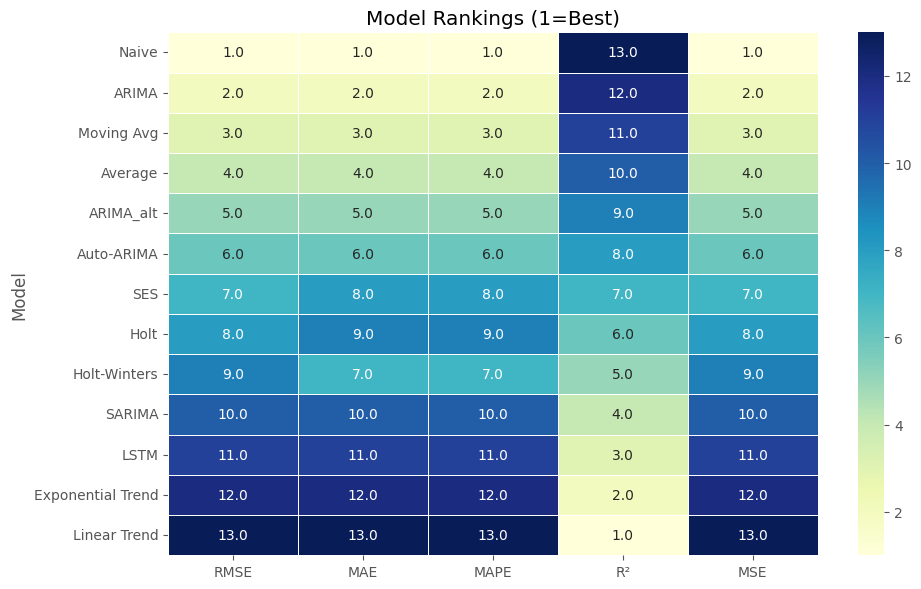

In [15]:
import seaborn as sns
# Create ranking for each metric
rank_df = results_df.copy()
for col in ['RMSE', 'MAE', 'MAPE', 'R²', 'MSE']:
    rank_df[col] = rank_df[col].rank(ascending=True)

plt.figure(figsize=(10, 6))
# Sort the DataFrame by RMSE before plotting
sorted_rank_df = rank_df.sort_values('RMSE').set_index('Model')[['RMSE', 'MAE', 'MAPE', 'R²', 'MSE']]
sns.heatmap(sorted_rank_df, 
            annot=True, cmap="YlGnBu", fmt=".1f",
            linewidths=.5)
plt.title("Model Rankings (1=Best)")
plt.tight_layout()
plt.show()

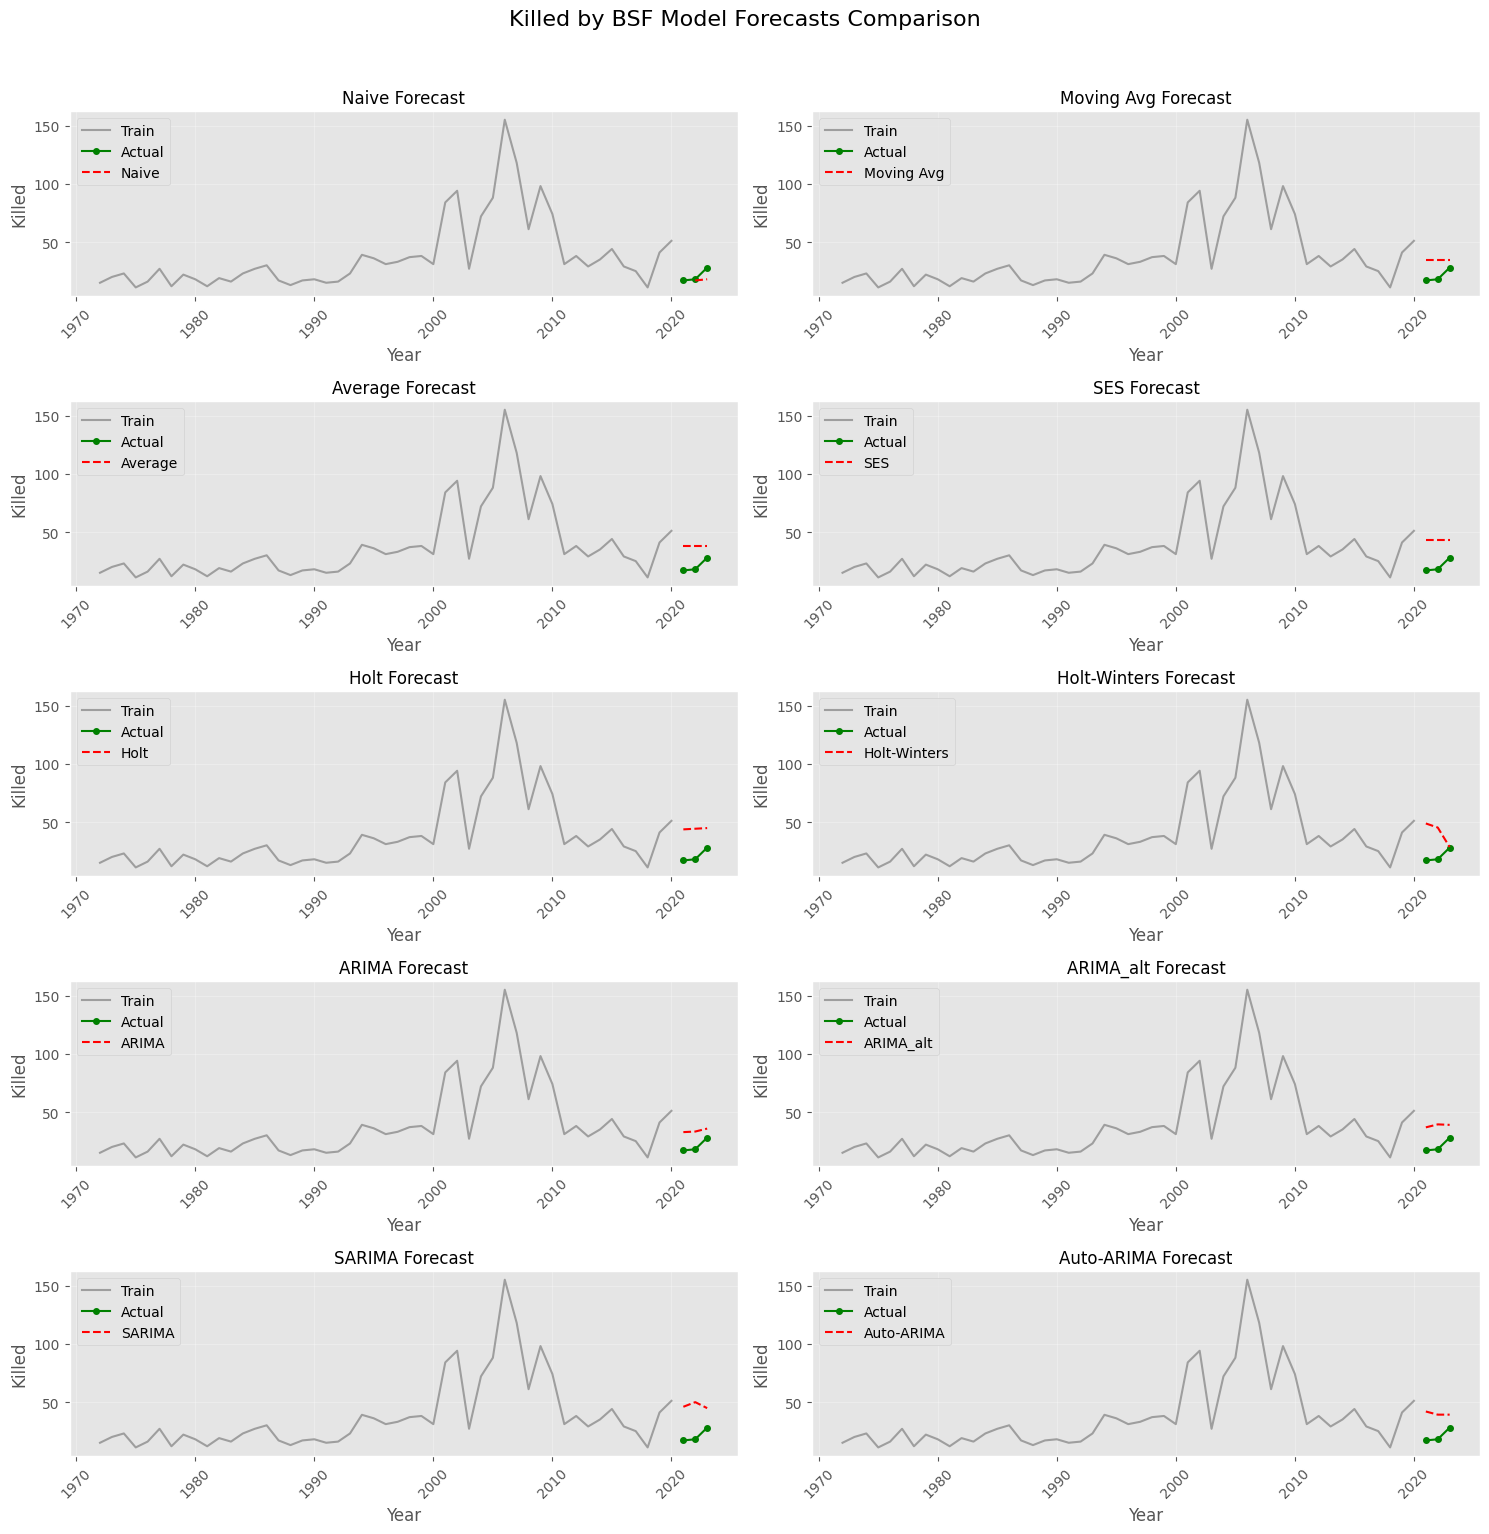

In [ ]:
# Selected models for comparison
selected_models = {
    'Naive': naive_forecast['Killed'],  # Fixed case to 'Killed'
    'Moving Avg': np.repeat(moving_average_forecast, len(test)),
    'Average': np.repeat(avg_forecast, len(test)),
    'SES': ses_forecast,
    'Holt': holt_forecast,
    'Holt-Winters': hw_forecast,
    'ARIMA': arima_forecast,
    'ARIMA_alt': arima_forecast_alt,
    'SARIMA': sarima_forecast,
    'Auto-ARIMA': auto_forecast
}

# Ensure forecasts are aligned with test.index
for model_name, forecast in selected_models.items():
    forecast = np.array(forecast).flatten()[:len(test)]  # Align length
    selected_models[model_name] = pd.Series(forecast, index=test.index)  # Align index

# Create subplot grid (5x2 to accommodate 10 models)
n_models = len(selected_models)
n_rows = (n_models + 1) // 2  # Ceiling division for rows
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 3 * n_rows))
fig.suptitle('Killed by BSF Model Forecasts Comparison', fontsize=16, y=1.02)

# Flatten axes for iteration (handle case where axes is 1D or 2D)
axes = np.array(axes).flatten() if n_models > 1 else [axes]

# Plot each model in its own subplot
for ax, (model_name, forecast) in zip(axes, selected_models.items()):
    # Plot train, test, and forecast
    ax.plot(train.index, train['Killed'], label='Train', color='gray', alpha=0.7)
    ax.plot(test.index, test['Killed'], label='Actual', color='green', marker='o', markersize=4)
    ax.plot(test.index, forecast, label=model_name, color='red', linestyle='--')
    
    # Customize subplot
    ax.set_title(f'{model_name} Forecast', fontsize=12)
    ax.set_xlabel('Year')
    ax.set_ylabel('Killed')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)
    
    # Optional: Format x-axis for dates (if DatetimeIndex)
    if isinstance(test.index, pd.DatetimeIndex):
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Hide unused subplots (if any)
for ax in axes[n_models:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

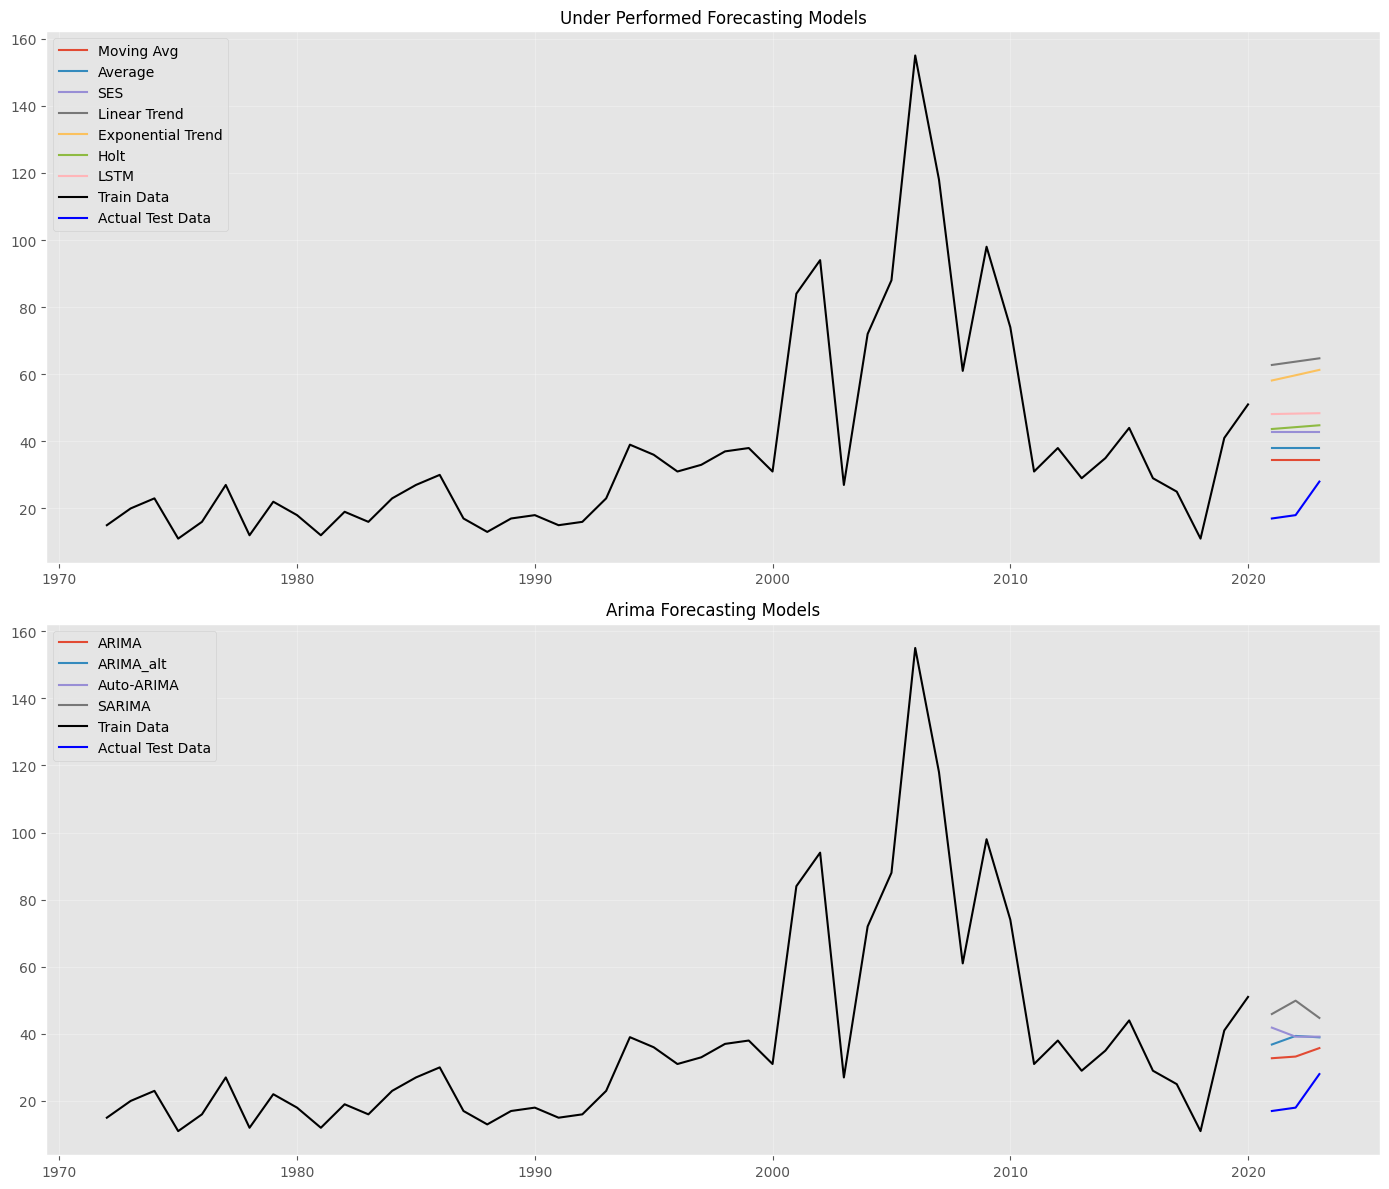

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Under Performed models
simple_models = ['Moving Avg', 'Average', 'SES', 'Linear Trend', 'Exponential Trend', 'Holt', 'LSTM'] 
for name in simple_models:
    ax1.plot(test.index, models[name], label=name)
ax1.set_title('Under Performed Forecasting Models', fontsize=12)

# Arima models
advanced_models = ['ARIMA', 'ARIMA_alt', 'Auto-ARIMA', 'SARIMA']  
for name in advanced_models:
    ax2.plot(test.index, models[name], label=name)
ax2.set_title('Arima Forecasting Models', fontsize=12)

# Shared elements
for ax in [ax1, ax2]:
    ax.plot(train.index, train['Killed'], color='black', label='Train Data')
    ax.plot(test.index, test['Killed'], color='blue', label='Actual Test Data')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook
with open("Border_Killing_inBD_byBSF_Prediction.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Export to HTML
html_exporter = HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(nb)

# Write to file
with open("your_notebook.html", "w") as f:
    f.write(html_data)
